# Lab: Build, Train, and Evaluate a Machine Learning Pipeline for Predicting Customer Churn

### Lab Objectives:
- Perform **exploratory data analysis (EDA)** to understand patterns in the dataset.
- Build a **supervised learning pipeline** for churn prediction.
- Evaluate the model using metrics like **precision, recall, and F1-score**.
- Prepare a short **"client update"** summarizing key insights and proposed actions.

## Scenario:
"Your retail client has provided customer behavior data and needs a predictive model to identify at-risk customers. Your task is to build the model and prepare a presentation summarizing findings and recommendations."

### Task 1: Perform EDA to understand patterns in the dataset.

In [1]:
# Import Libraries
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

In [2]:
# Load the Dataset
df = pd.read_csv("../data/retail-sales-data.csv")
df.head()

Transaction ID        Date Customer ID  Gender  Age Product Category  \
0               1  2023-11-24     CUST001    Male   34           Beauty   
1               2  2023-02-27     CUST002  Female   26         Clothing   
2               3  2023-01-13     CUST003    Male   50      Electronics   
3               4  2023-05-21     CUST004    Male   37         Clothing   
4               5  2023-05-06     CUST005    Male   30           Beauty   

   Quantity  Price per Unit  Total Amount  
0         3              50           150  
1         2             500          1000  
2         1              30            30  
3         1             500           500  
4         2              50           100

In [3]:
# Display basic statistics and check for missing values.

print(df.info())
print(df.describe())
print(df.isnull().sum())

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1000 entries, 0 to 999
Data columns (total 9 columns):
 #   Column            Non-Null Count  Dtype 
---  ------            --------------  ----- 
 0   Transaction ID    1000 non-null   int64 
 1   Date              1000 non-null   object
 2   Customer ID       1000 non-null   object
 3   Gender            1000 non-null   object
 4   Age               1000 non-null   int64 
 5   Product Category  1000 non-null   object
 6   Quantity          1000 non-null   int64 
 7   Price per Unit    1000 non-null   int64 
 8   Total Amount      1000 non-null   int64 
dtypes: int64(5), object(4)
memory usage: 70.4+ KB
None
       Transaction ID         Age     Quantity  Price per Unit  Total Amount
count     1000.000000  1000.00000  1000.000000     1000.000000   1000.000000
mean       500.500000    41.39200     2.514000      179.890000    456.000000
std        288.819436    13.68143     1.132734      189.681356    559.997632
min          1.000000    

## Cleaning and Transforming Data

In [4]:
df.drop(['Transaction ID', 'Customer ID'], axis=1, inplace= True)

In [5]:
# Convert date(object) column to Date type
df['Date'] = pd.to_datetime(df['Date'])

              mean     sum
Gender                    
Female  456.549020  232840
Male    455.428571  223160


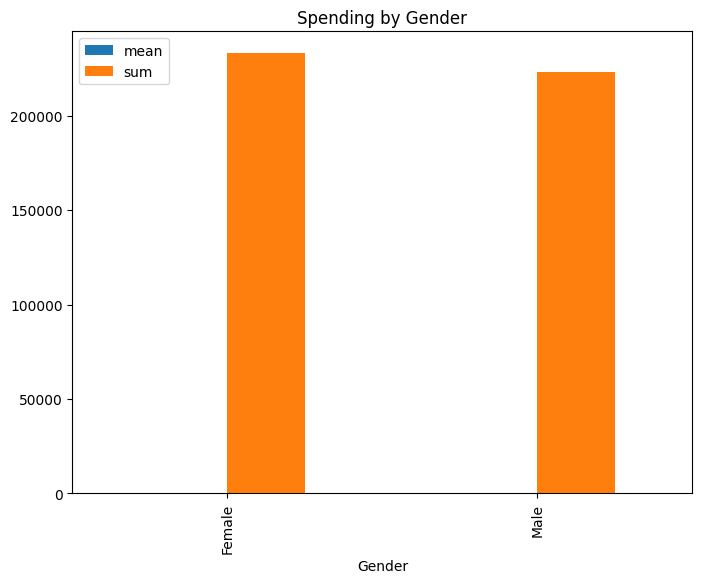

In [6]:
# Visualize Key Patterns:
gender_spending = df.groupby('Gender')['Total Amount'].agg(['mean', 'sum'])
gender_spending.plot(kind='bar', figsize=(8, 6), title='Spending by Gender')
print(gender_spending)
plt.show()

Age Group
18-30    483.055556
31-40    497.150259
41-50    424.411765
51-64    425.910543
Name: Total Amount, dtype: float64


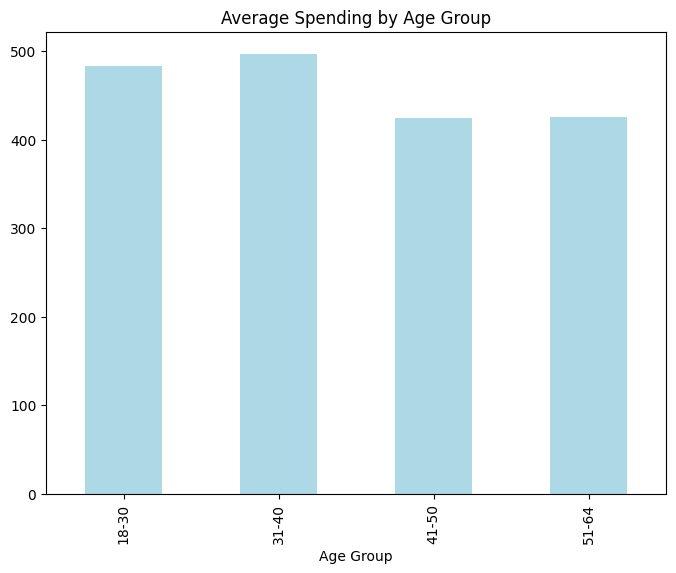

In [7]:
# Group by Age Bins
df['Age Group'] = pd.cut(df['Age'], bins=[18, 30, 40, 50, 64], labels=['18-30', '31-40', '41-50', '51-64'])
age_group_spending = df.groupby('Age Group', observed=True)['Total Amount'].mean()
print(age_group_spending)

age_group_spending.plot(kind='bar', figsize=(8, 6), title='Average Spending by Age Group', color='lightblue')
plt.show()

## Analyze monthly sales trends and weekday vs. weekend sales

Month
2023-01    35450
2023-02    44060
2023-03    28990
2023-04    33870
2023-05    53150
2023-06    36715
2023-07    35465
2023-08    36960
2023-09    23620
2023-10    46580
2023-11    34920
2023-12    44690
2024-01     1530
Freq: M, Name: Total Amount, dtype: int64


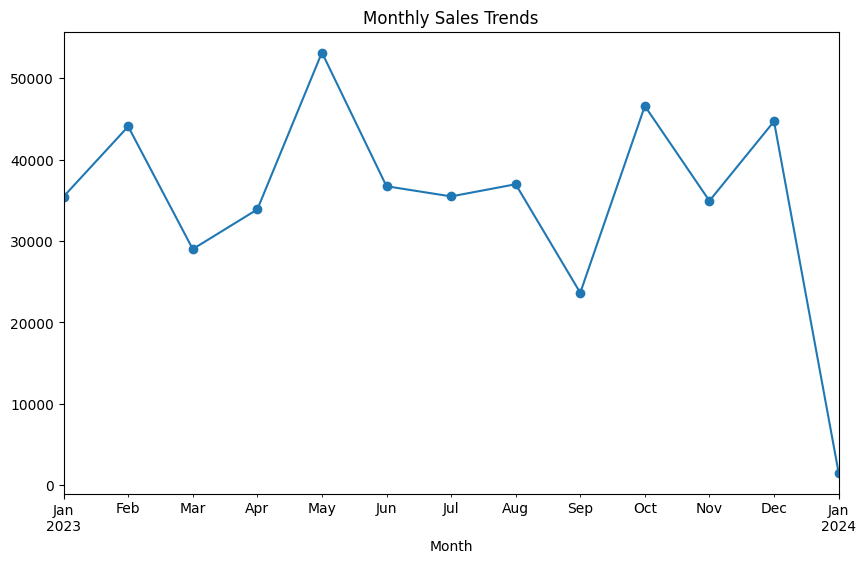

In [8]:
# Sales trends by month
df['Month'] = df['Date'].dt.to_period('M')
monthly_sales = df.groupby('Month')['Total Amount'].sum()
print(monthly_sales)

monthly_sales.plot(kind='line', marker='o', figsize=(10, 6), title='Monthly Sales Trends')

plt.show()

Weekday
Friday       66290
Monday       70250
Saturday     78815
Sunday       58600
Thursday     53835
Tuesday      69440
Wednesday    58770
Name: Total Amount, dtype: int64


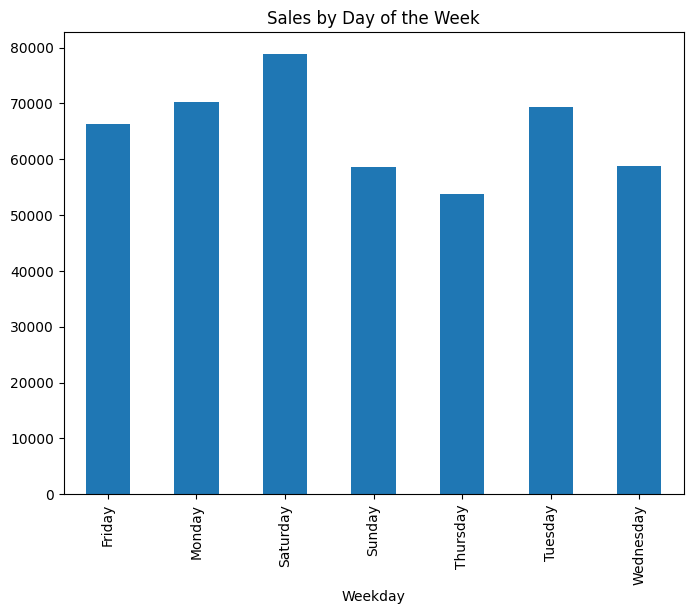

In [9]:
# Weekday vs Weekend Sales
df['Weekday'] = df['Date'].dt.day_name()
weekday_sales = df.groupby('Weekday')['Total Amount'].sum()
weekday_sales.sort_index().plot(kind='bar', figsize=(8, 6), title='Sales by Day of the Week')
print(weekday_sales)
plt.show()

## Analyse the months with maximum and minimum sales

In [10]:
# Find the month with max and min sales
max_month = monthly_sales.idxmax()
max_sales_month = weekday_sales.max()
min_month = monthly_sales.idxmin()
min_sales_month = weekday_sales.min()

print(f"Month with maximum sales: {max_month} (${max_sales_month})")
print(f"Month with minimum sales: {min_month} (${min_sales_month})")

Month with maximum sales: 2023-05 ($78815)
Month with minimum sales: 2024-01 ($53835)


### Quantities Purchesed By Categories

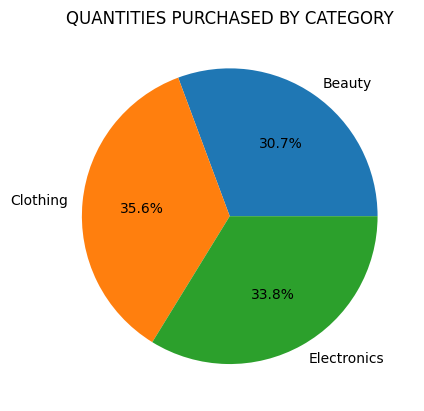

In [11]:
prod_cat = df.groupby('Product Category')['Quantity'].sum().reset_index()
plt.pie(prod_cat['Quantity'], labels= prod_cat['Product Category'], autopct = '%1.1f%%')
plt.title('QUANTITIES PURCHASED BY CATEGORY')
plt.show()

## Task 2: Build the Churn Prediction Pipeline

### Import required libraries

In [12]:
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LinearRegression
from sklearn.preprocessing import StandardScaler 
from sklearn.metrics import mean_squared_error, r2_score, classification_report, accuracy_score

In [13]:
# Prepare the data for modeling
X = df[['Age', 'Quantity', 'Price per Unit']]
y = df['Total Amount']

# Split the data into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)
sc = StandardScaler() 
X_train = sc.fit_transform(X_train) 
X_test = sc.transform(X_test) 

In [14]:
# Import RandomForestClassifier 
from sklearn.ensemble import RandomForestClassifier 

# Instantiate the classifier 
clf = RandomForestClassifier() 

# Fit to the training data 
clf.fit(X_train, y_train) 
y_pred = clf.predict(X_test)
print("Accuracy Score :", accuracy_score(y_test, y_pred)*100, "%")

Accuracy Score : 99.5 %


In [15]:
# Train a linear regression model

model = LinearRegression()
model.fit(X_train, y_train)
lr_pred = model.predict(X_test)

print("\nLinear Regression Performance:")
print(f'Mean Squared Error: {mean_squared_error(y_test, lr_pred)}')
print(f'R-squared Score: {r2_score(y_test, lr_pred)}')


Linear Regression Performance:
Mean Squared Error: 41896.21322134363
R-squared Score: 0.856877226425043


## Task3: Evaluate the model using metrics like precision, recall, and F1-score.

In [16]:
# Evaluate the model
mse = mean_squared_error(y_test, y_pred)
r2 = r2_score(y_test, y_pred)
print(f'Mean Squared Error: {mse}')
print(f'R-squared: {r2}')
y_test = y_test.astype(int)  # Convert y_test to integer labels, if necessary
y_pred = y_pred.astype(int)
print(classification_report(y_test,y_pred))

Mean Squared Error: 0.125
R-squared: 0.9999995729841596
              precision    recall  f1-score   support

          25       1.00      0.90      0.95        10
          30       0.88      1.00      0.93         7
          50       1.00      1.00      1.00        17
          60       1.00      1.00      1.00         9
          75       1.00      1.00      1.00         8
          90       1.00      1.00      1.00         9
         100       1.00      1.00      1.00        23
         120       1.00      1.00      1.00         7
         150       1.00      1.00      1.00         9
         200       1.00      1.00      1.00        17
         300       1.00      1.00      1.00        15
         500       1.00      1.00      1.00         8
         600       1.00      1.00      1.00         5
         900       1.00      1.00      1.00        14
        1000       1.00      1.00      1.00        12
        1200       1.00      1.00      1.00        10
        1500       1.00  

In [17]:
from sklearn.metrics import confusion_matrix 
print(confusion_matrix(y_test, y_pred)) 

[[ 9  1  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0]
 [ 0  7  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0]
 [ 0  0 17  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0]
 [ 0  0  0  9  0  0  0  0  0  0  0  0  0  0  0  0  0  0]
 [ 0  0  0  0  8  0  0  0  0  0  0  0  0  0  0  0  0  0]
 [ 0  0  0  0  0  9  0  0  0  0  0  0  0  0  0  0  0  0]
 [ 0  0  0  0  0  0 23  0  0  0  0  0  0  0  0  0  0  0]
 [ 0  0  0  0  0  0  0  7  0  0  0  0  0  0  0  0  0  0]
 [ 0  0  0  0  0  0  0  0  9  0  0  0  0  0  0  0  0  0]
 [ 0  0  0  0  0  0  0  0  0 17  0  0  0  0  0  0  0  0]
 [ 0  0  0  0  0  0  0  0  0  0 15  0  0  0  0  0  0  0]
 [ 0  0  0  0  0  0  0  0  0  0  0  8  0  0  0  0  0  0]
 [ 0  0  0  0  0  0  0  0  0  0  0  0  5  0  0  0  0  0]
 [ 0  0  0  0  0  0  0  0  0  0  0  0  0 14  0  0  0  0]
 [ 0  0  0  0  0  0  0  0  0  0  0  0  0  0 12  0  0  0]
 [ 0  0  0  0  0  0  0  0  0  0  0  0  0  0  0 10  0  0]
 [ 0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0 13  0]
 [ 0  0  0  0  0  0  0  0  0  0

## To reduce customer churn, loyalty programs can be designed strategically to engage at-risk customers, address their concerns, and enhance their satisfaction. Here are some effective loyalty strategies for avoiding churn:
- Provide discounts on frequently purchased items.
- Offer a “We Miss You” discount to customers who haven't shopped recently.
- Encourages repeat purchases to accumulate points.
- Offer memberships with exclusive perks like free shipping, cashback, or premium services.